In [ ]:
!git clone https://github.com/ghqls1237/CS492_CrowdCounting.git

fatal: destination path 'CS492_CrowdCounting' already exists and is not an empty directory.


In [ ]:
!pip3 install torchvision
!pip install tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
Model을 처음 training할 때
  1. model_to_load = False로 설정
  2. LAST_EPOCH = -1로 설정
기존의 Model 위에 
  1. model_to_load = True 로 설정
  2. LAST_EPOCH을 test된 마지막 epoch으로 설정


'''


import numpy as np
import time
import torch
import torch.nn as nn
import os
#import visdom
import random
from tqdm import tqdm as tqdm
import pickle

from CS492_CrowdCounting.trialnet1 import CANNet
from CS492_CrowdCounting.my_dataset import CrowdDataset

if __name__=="__main__":
    # configuration
    train_image_root='/content/drive/My Drive/ShanghaiTech/part_A/train_data/images'  #image
    train_dmap_root='/content/drive/My Drive/ShanghaiTech/part_A/train_data/ground-truth' #density map
    test_image_root='/content/drive/My Drive/ShanghaiTech/part_A/test_data/images'
    test_dmap_root='/content/drive/My Drive/ShanghaiTech/part_A/test_data/ground-truth'
    img_root = '/content/drive/My Drive/ShanghaiTech/Test_Folder'
    gpu_or_cpu='cuda' # use cuda or cpu
    lr                = 1e-7
    batch_size        = 1
    momentum          = 0.95
    epochs            = 20000 
    steps             = [-1,1,100,150]
    scales            = [1,1,1,1]
    workers           = 4
    seed              = time.time()
    print_freq        = 30 
    model_to_load     = True  # 처음 training 시킬 때 False로 바꾸기

    "CHANGE THIS PART ACCORDING TO YOUR NEED. IF YOU WANT TO CONTINUE ON FROM LAST TRAINING, TYPE IN THE LAST EPOCH OF YOUR TRAINING"
    LAST_EPOCH        = 141


    #vis=visdom.Visdom()
    device=torch.device(gpu_or_cpu)
    torch.cuda.manual_seed(seed)
    model=CANNet().to(device)
    criterion=nn.MSELoss(size_average=False).to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr,
                              momentum=momentum,
                              weight_decay=0)
#   optimizer=torch.optim.Adam(model.parameters(),lr)
    train_dataset=CrowdDataset(train_image_root,train_dmap_root,gt_downsample=8,phase='train')
    train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_dataset=CrowdDataset(test_image_root,test_dmap_root,gt_downsample=8,phase='test')
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

    if not os.path.exists('./checkpoints'):
        os.mkdir('./checkpoints')
    min_mae=10000
    min_epoch=0
    train_loss_list=[]
    epoch_list=[]
    test_error_list=[]

    # 맨 처음부터 training시킬 때는 if 부분 주석 처리
    if model_to_load:
      if LAST_EPOCH >= 0:
        with open('/content/drive/My Drive/AI_Project2/checkpoints/train_loss_list.pkl', 'rb') as f:
          train_loss_list = pickle.load(f)
        with open('/content/drive/My Drive/AI_Project2/checkpoints/test_error_list.pkl', 'rb') as f:
          test_error_list = pickle.load(f)
        LAST_EPOCH = LAST_EPOCH - 1 if len(train_loss_list)!=len(test_error_list) else LAST_EPOCH
        train_loss_list = train_loss_list[:LAST_EPOCH+1]
        test_error_list = test_error_list[:LAST_EPOCH+1]
      model.load_state_dict(torch.load("/content/drive/My Drive/AI_Project2/checkpoints/epoch_{}.pth".format(LAST_EPOCH)))

    for i, (img, gt_dmap) in enumerate(tqdm(test_loader)):
      print("\nIMAGE NUMBER: {}".format(i))
      img=img.to(device)
      gt_dmap=gt_dmap.to(device)
      # forward propagation
      et_dmap=model(img)
      print(type(img))
      print(img.shape)
      if i==1:
        break

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

  0%|          | 0/182 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  


IMAGE NUMBER: 0
<class 'torch.Tensor'>
torch.Size([1, 3, 392, 592])

IMAGE NUMBER: 1
<class 'torch.Tensor'>
torch.Size([1, 3, 608, 464])


'\n    for epoch in range(LAST_EPOCH+1,epochs):\n        # training phase\n        model.train()\n        epoch_loss=0\n        for i,(img,gt_dmap) in enumerate(tqdm(train_loader)):\n            img=img.to(device)\n            gt_dmap=gt_dmap.to(device)\n            # forward propagation\n            et_dmap=model(img)\n            # calculate loss\n            loss=criterion(et_dmap,gt_dmap)\n            epoch_loss+=loss.item()\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n        #print("epoch:",epoch,"loss:",epoch_loss/len(train_loader))\n        epoch_list.append(epoch)\n        train_loss_list.append((epoch_loss/len(train_loader)))\n        # Saves train_loss_list\n        with open(\'/content/drive/My Drive/AI_Project2/checkpoints/train_loss_list.pkl\', \'wb\') as f:\n          pickle.dump(train_loss_list, f)\n        torch.save(model.state_dict(),F"/content/drive/My Drive/AI_Project2/checkpoints/epoch_"+str(epoch)+".pth")\n    \n 

# Model Estimation of the Density Map

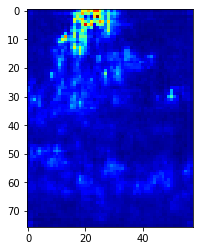

In [ ]:
import matplotlib.pyplot as plt

et_dmap_cpu = et_dmap.to('cpu')
et_dmap_cpu = et_dmap_cpu.detach().numpy()
et_dmap_cpu = et_dmap_cpu.reshape(et_dmap_cpu.shape[2],et_dmap_cpu.shape[3])

plt.imshow(et_dmap_cpu, cmap='jet', interpolation='nearest')
plt.show()


In [ ]:
et_dmap.data.sum().item() # expected number of people

148.6949920654297

# Actual Density Map

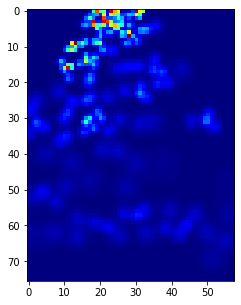

In [ ]:
gt_dmap_cpu = gt_dmap.to('cpu')
gt_dmap_cpu = gt_dmap_cpu.detach().numpy()
gt_dmap_cpu = gt_dmap_cpu.reshape(gt_dmap_cpu.shape[2],gt_dmap_cpu.shape[3])

plt.imshow(gt_dmap_cpu, cmap='jet', interpolation='nearest')
plt.show()

In [ ]:
gt_dmap.data.sum().item()

128.8002471923828

In [ ]:
print(type(img))

<class 'torch.Tensor'>


# This parts lets you make a density map of a photo of your choice and predict the number of people based on the density map.

In [ ]:
import cv2
from torchvision import transforms
torch.cuda.empty_cache()

img_names=[filename for filename in os.listdir(img_root) \
                           if os.path.isfile(os.path.join(img_root,filename))]


def img_transform(index, gt_downsample=8):
  '''
  transforms the jpg image suitable as the model input
  '''
  assert index <= len(img_names), 'index range error'
  img_name=img_names[index]
  img=plt.imread(os.path.join(img_root,img_name))/255# convert from [0,255] to [0,1]

  if len(img.shape)==2: # expand grayscale image to three channel.
      img=img[:,:,np.newaxis]
      img=np.concatenate((img,img,img),2)

  if gt_downsample>1: # to downsample image and density-map to match deep-model.
      ds_rows=int(img.shape[0]//gt_downsample)
      ds_cols=int(img.shape[1]//gt_downsample)
      img = cv2.resize(img,(ds_cols*gt_downsample,ds_rows*gt_downsample))
      img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)

      img_tensor=torch.tensor(img,dtype=torch.float)
      img_tensor=transforms.functional.normalize(img_tensor,mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
  img_tensor = img_tensor.reshape(1, img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2])
  return img_tensor

In [ ]:
test_img = img_transform(1)
print(test_img.shape)

torch.Size([1, 3, 144, 232])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


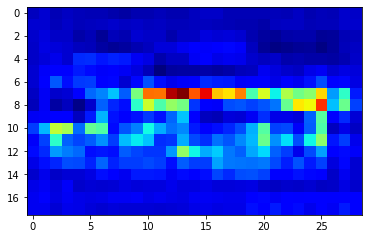

In [ ]:
test_dmap=model(test_img.to('cuda'))

test_dmap_cpu = test_dmap.to('cpu')
test_dmap_cpu = test_dmap_cpu.detach().numpy()
test_dmap_cpu = test_dmap_cpu.reshape(test_dmap_cpu.shape[2],test_dmap_cpu.shape[3])

plt.imshow(test_dmap_cpu, cmap='jet', interpolation='nearest')
plt.show()

In [ ]:
test_dmap.data.sum().item()

37.843074798583984